In [2]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [3]:

# Dataset directory
dataset_dir = './tiny-imagenet-200'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(train_dir, transform=transform_train)
val_dataset = ImageFolder(val_dir, transform=transform_val)


In [4]:

class ComplexCNN(nn.Module):
    def __init__(self, num_classes=200, norm_layer=None, num_groups=None):
        super(ComplexCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            self._get_norm_layer(norm_layer, 64, [64, 64] if norm_layer == nn.LayerNorm else None),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            self._get_norm_layer(norm_layer, 64, [64, 64] if norm_layer == nn.LayerNorm else None),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            self._get_norm_layer(norm_layer, 128, [128, 32, 32] if norm_layer == nn.LayerNorm else None),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            self._get_norm_layer(norm_layer, 128, [128, 32, 32] if norm_layer == nn.LayerNorm else None),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            self._get_norm_layer(norm_layer, 256, [256, 16, 16] if norm_layer == nn.LayerNorm else None),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            self._get_norm_layer(norm_layer, 256, [256, 16, 16] if norm_layer == nn.LayerNorm else None),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            self._get_norm_layer(norm_layer, 256, [256, 16, 16] if norm_layer == nn.LayerNorm else None),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def _get_norm_layer(self, norm_layer, num_features, normalized_shape=None):
        if norm_layer == nn.GroupNorm:
            return norm_layer(num_groups, num_features)
        elif norm_layer == nn.LayerNorm:
            return norm_layer(normalized_shape)
        elif norm_layer == nn.InstanceNorm2d:
            return norm_layer(num_features, affine=True)
        elif norm_layer == nn.BatchNorm2d:
            return norm_layer(num_features)
        else:
            return nn.Identity()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [4]:
### =============== Batch Size = 128 ================ ### 
def train_model(model_class, norm_layer=None, num_groups=None, batch_size=128, num_epochs=10):
    model = model_class(norm_layer=norm_layer, num_groups=num_groups).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    epoch_losses = []
    start_time = time.time()
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    end_time = time.time()
    training_time = end_time - start_time
    return training_time, epoch_losses

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for the training
batch_size = 128
num_epochs = 10

# Compare training times and losses for ComplexCNN
normalizations = [
    ('BatchNorm', nn.BatchNorm2d, None),
    ('LayerNorm', nn.LayerNorm, None),
    ('InstanceNorm', nn.InstanceNorm2d, None),
    ('GroupNorm_32', nn.GroupNorm, 32),
    ('GroupNorm_16', nn.GroupNorm, 16),
    ('GroupNorm_8', nn.GroupNorm, 8),
    ('GroupNorm_4', nn.GroupNorm, 4),
    ('GroupNorm_2', nn.GroupNorm, 2)
]

results_complex = {norm_name: {'time': None, 'losses': []} for norm_name, _, _ in normalizations}

for norm_name, norm_layer, num_groups in normalizations:
    print(f'Normalization: {norm_name}')
    training_time, epoch_losses = train_model(ComplexCNN, norm_layer=norm_layer, num_groups=num_groups, batch_size=batch_size, num_epochs=num_epochs)
    results_complex[norm_name]['time'] = training_time
    results_complex[norm_name]['losses'] = epoch_losses


Normalization: BatchNorm
Epoch [1/10], Loss: 5.0400
Epoch [2/10], Loss: 4.6456
Epoch [3/10], Loss: 4.4292
Epoch [4/10], Loss: 4.2749
Epoch [5/10], Loss: 4.1460
Epoch [6/10], Loss: 4.0374
Epoch [7/10], Loss: 3.9363
Epoch [8/10], Loss: 3.8592
Epoch [9/10], Loss: 3.7740
Epoch [10/10], Loss: 3.7186
Normalization: LayerNorm
Epoch [1/10], Loss: 5.3006
Epoch [2/10], Loss: 5.2601
Epoch [3/10], Loss: 5.1193
Epoch [4/10], Loss: 5.0060
Epoch [5/10], Loss: 4.9172
Epoch [6/10], Loss: 4.8143
Epoch [7/10], Loss: 4.7092
Epoch [8/10], Loss: 4.6102
Epoch [9/10], Loss: 4.5199
Epoch [10/10], Loss: 4.4474
Normalization: InstanceNorm
Epoch [1/10], Loss: 5.2933
Epoch [2/10], Loss: 5.1957
Epoch [3/10], Loss: 5.0929
Epoch [4/10], Loss: 5.0308
Epoch [5/10], Loss: 4.9631
Epoch [6/10], Loss: 4.8997
Epoch [7/10], Loss: 4.8438
Epoch [8/10], Loss: 4.8028
Epoch [9/10], Loss: 4.7620
Epoch [10/10], Loss: 4.7057
Normalization: GroupNorm_32
Epoch [1/10], Loss: 5.2970
Epoch [2/10], Loss: 5.2135
Epoch [3/10], Loss: 5.1124


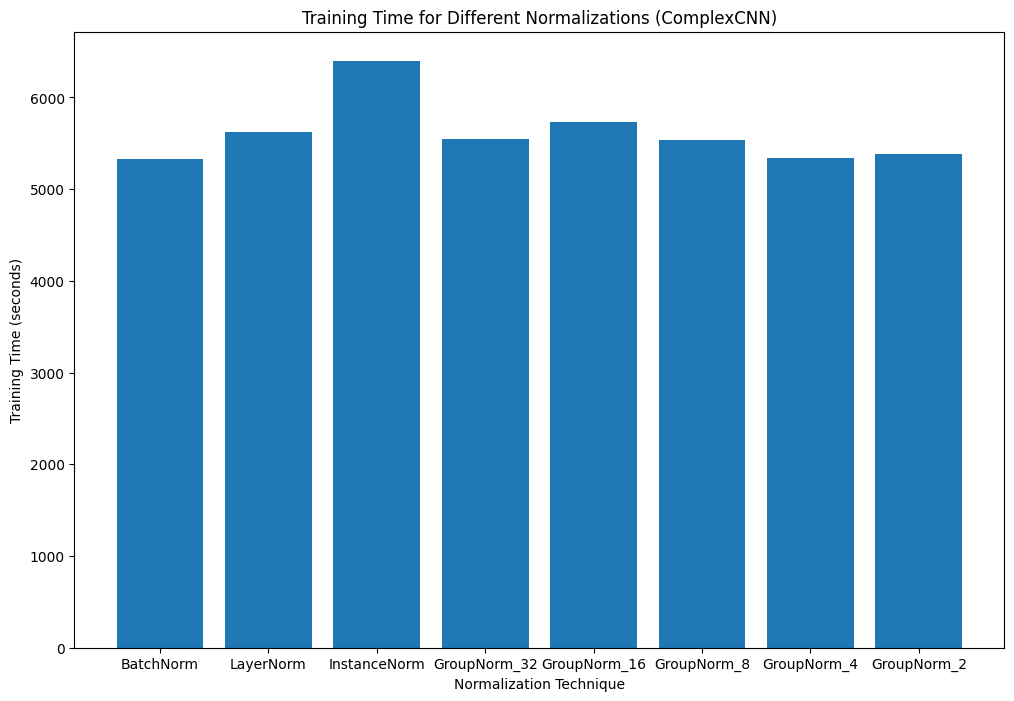

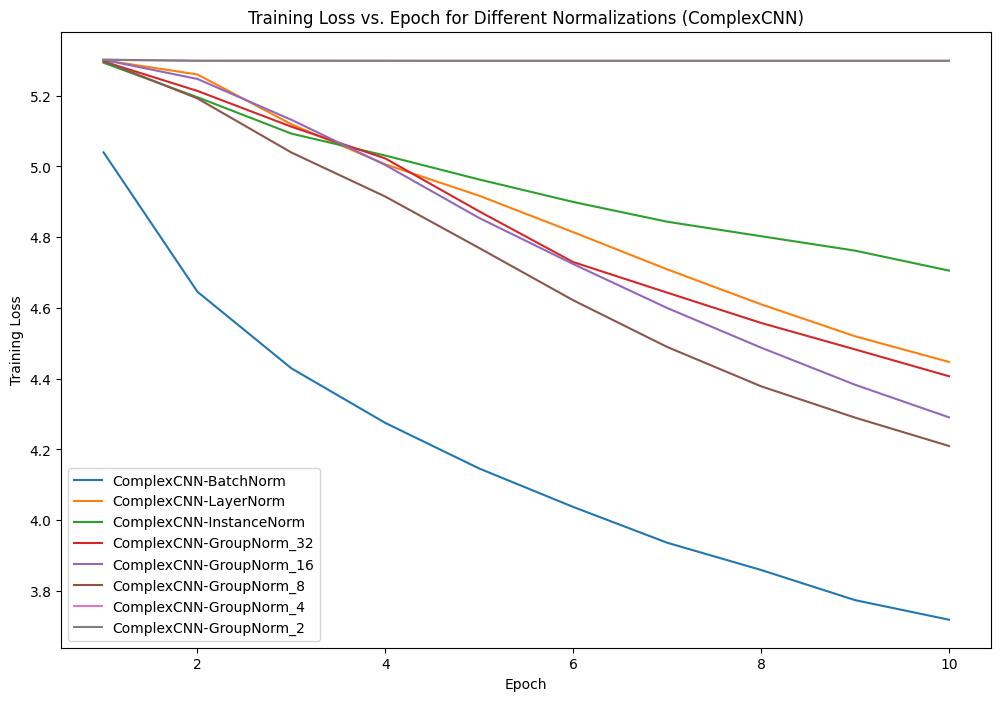

In [ ]:

# Plot the training time results
plt.figure(figsize=(12, 8))
norm_names = [norm_name for norm_name, _, _ in normalizations]
training_times = [results_complex[norm_name]['time'] for norm_name in norm_names]
plt.bar(norm_names, training_times)
plt.xlabel('Normalization Technique')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Different Normalizations (ComplexCNN)')
plt.show()

# Plot the training loss vs. epoch results
plt.figure(figsize=(12, 8))
for norm_name in results_complex:
    plt.plot(range(1, num_epochs + 1), results_complex[norm_name]['losses'], label=f'ComplexCNN-{norm_name}')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epoch for Different Normalizations (ComplexCNN)')
plt.legend()
plt.show()


In [5]:
### ================== Batch Size = 64 ======================= ###
def train_model(model_class, norm_layer=None, num_groups=None, batch_size=128, num_epochs=10):
    model = model_class(norm_layer=norm_layer, num_groups=num_groups).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    epoch_losses = []
    start_time = time.time()
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    end_time = time.time()
    training_time = end_time - start_time
    return training_time, epoch_losses

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for the training
batch_size = 64
num_epochs = 10

# Compare training times and losses for ComplexCNN
normalizations = [
    ('BatchNorm', nn.BatchNorm2d, None),
    ('LayerNorm', nn.LayerNorm, None),
    ('InstanceNorm', nn.InstanceNorm2d, None),
    ('GroupNorm_32', nn.GroupNorm, 32),
    ('GroupNorm_16', nn.GroupNorm, 16),
    ('GroupNorm_8', nn.GroupNorm, 8),
    ('GroupNorm_4', nn.GroupNorm, 4),
    ('GroupNorm_2', nn.GroupNorm, 2)
]

results_complex = {norm_name: {'time': None, 'losses': []} for norm_name, _, _ in normalizations}

for norm_name, norm_layer, num_groups in normalizations:
    print(f'Normalization: {norm_name}')
    training_time, epoch_losses = train_model(ComplexCNN, norm_layer=norm_layer, num_groups=num_groups, batch_size=batch_size, num_epochs=num_epochs)
    results_complex[norm_name]['time'] = training_time
    results_complex[norm_name]['losses'] = epoch_losses



Normalization: BatchNorm
Epoch [1/10], Loss: 5.0294


In [ ]:
# Plot the training time results
plt.figure(figsize=(12, 8))
norm_names = [norm_name for norm_name, _, _ in normalizations]
training_times = [results_complex[norm_name]['time'] for norm_name in norm_names]
plt.bar(norm_names, training_times)
plt.xlabel('Normalization Technique')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Different Normalizations (ComplexCNN)')
plt.show()

# Plot the training loss vs. epoch results
plt.figure(figsize=(12, 8))
for norm_name in results_complex:
    plt.plot(range(1, num_epochs + 1), results_complex[norm_name]['losses'], label=f'ComplexCNN-{norm_name}')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epoch for Different Normalizations (ComplexCNN)')
plt.legend()
plt.show()
